# Imports

In [79]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import pandas as pd
import numpy as np

import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras import regularizers
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load Data

In [80]:
data = pd.read_csv("data/data_cleaned.csv")

# Data Preparation

In [81]:
# one hot
data = pd.get_dummies(data, prefix = ["HEAT", "AC", "STYLE", "STRUCT", "GRADE", "CNDTN", "EXTWALL", "INTWALL", "ROOF", "ASSESSMENT_SUBNBHD"], columns = ["HEAT", "AC", "STYLE", "STRUCT", "GRADE", "CNDTN", "EXTWALL", "INTWALL", "ROOF", "ASSESSMENT_SUBNBHD"])

In [82]:
# split
x_data = data.drop(["PRICE"], axis=1)
y_data = data["PRICE"]

In [83]:
# normalization
x_data = x_data.astype(float)
x_data = x_data.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [84]:
# train & test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

In [85]:
x_train.head(5)

,BATHRM,HF_BATHRM,NUM_UNITS,ROOMS,BEDRM,STORIES,SALE_NUM,GBA,KITCHENS,FIREPLACES,...,ASSESSMENT_SUBNBHD_050 D Spring Valley,ASSESSMENT_SUBNBHD_052 A Trinidad,ASSESSMENT_SUBNBHD_052 B Trinidad,ASSESSMENT_SUBNBHD_052 C Trinidad,ASSESSMENT_SUBNBHD_054 A Wesley Heights,ASSESSMENT_SUBNBHD_054 B Wesley Heights,ASSESSMENT_SUBNBHD_056 A Woodridge,ASSESSMENT_SUBNBHD_056 B Woodridge,ASSESSMENT_SUBNBHD_056 C Woodridge,ASSESSMENT_SUBNBHD_056 D Woodridge
19085,0.272727,0.090909,0.166667,0.300000,0.20,0.15,0.000000,0.248879,0.022727,0.076923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36371,0.090909,0.090909,0.166667,0.166667,0.15,0.10,0.000000,0.054914,0.022727,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45599,0.272727,0.000000,0.166667,0.266667,0.15,0.10,0.071429,0.146799,0.022727,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39765,0.090909,0.000000,0.166667,0.133333,0.10,0.10,0.000000,0.037923,0.022727,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47208,0.181818,0.000000,0.166667,0.233333,0.15,0.10,0.000000,0.056273,0.022727,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
y_train.head(5)

19085    1380000.0
36371      99500.0
45599     440000.0
39765     230000.0
47208     117000.0
Name: PRICE, dtype: float64

# NN

In [94]:
model = Sequential()
model.add(Dense(256, activation="tanh", kernel_initializer='normal', input_shape=(252,)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu", kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu", kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu", kernel_initializer='normal', 
    kernel_regularizer=regularizers.l1(0.02), bias_regularizer=regularizers.l1(0.02)))
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu", kernel_initializer='normal', 
    kernel_regularizer=regularizers.l1_l2(0.02), bias_regularizer=regularizers.l1_l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu", kernel_initializer='normal'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(
    loss='mean_squared_error',
    optimizer='nadam',
    metrics=["mae"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 256)               64768     
_________________________________________________________________
batch_normalization_29 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_59 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 512)               131584    
_________________________________________________________________
batch_normalization_30 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_60 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 512)               262656    
__________

In [95]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint(filepath='./weights.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(x_train, 
          y_train,
          batch_size = 128,
          shuffle = True,
          epochs = 1000,
          validation_data = (x_test, y_test),
          callbacks=[es, mc])

Train on 51739 samples, validate on 25484 samples
Epoch 1/100
51739/51739 [==============================] - 36s 699us/step - loss: 275405155956.7213 - mean_absolute_error: 229775.4491 - val_loss: 210482810214.5848 - val_mean_absolute_error: 175563.9980

Epoch 00001: val_loss improved from inf to 210482810214.58484, saving model to ./weights.hdf5
Epoch 2/100
51739/51739 [==============================] - 33s 644us/step - loss: 231303830979.4673 - mean_absolute_error: 197228.1225 - val_loss: 201282662810.0179 - val_mean_absolute_error: 175722.6077

Epoch 00002: val_loss improved from 210482810214.58484 to 201282662810.01788, saving model to ./weights.hdf5
Epoch 3/100
51739/51739 [==============================] - 33s 647us/step - loss: 219161674777.1156 - mean_absolute_error: 194784.2253 - val_loss: 192085586199.0243 - val_mean_absolute_error: 173254.7572

Epoch 00003: val_loss improved from 201282662810.01788 to 192085586199.02432, saving model to ./weights.hdf5
Epoch 4/100
51739/51739


Epoch 00029: val_loss did not improve from 82110382530.84288
Epoch 30/100
51739/51739 [==============================] - 34s 657us/step - loss: 93842818611.4484 - mean_absolute_error: 165173.8590 - val_loss: 103590713666.0995 - val_mean_absolute_error: 140509.0183

Epoch 00030: val_loss did not improve from 82110382530.84288
Epoch 31/100
51739/51739 [==============================] - 34s 666us/step - loss: 108337116077.2511 - mean_absolute_error: 167502.7586 - val_loss: 132736268284.7854 - val_mean_absolute_error: 142005.0639

Epoch 00031: val_loss did not improve from 82110382530.84288
Epoch 32/100
51739/51739 [==============================] - 37s 707us/step - loss: 93331553301.4344 - mean_absolute_error: 166412.1252 - val_loss: 139736031964.4389 - val_mean_absolute_error: 145807.7053

Epoch 00032: val_loss did not improve from 82110382530.84288
Epoch 33/100
51739/51739 [==============================] - 36s 705us/step - loss: 113088228054.1555 - mean_absolute_error: 167666.3638 - v

51739/51739 [==============================] - 34s 660us/step - loss: 87268811438.6910 - mean_absolute_error: 158007.4879 - val_loss: 80289442468.1840 - val_mean_absolute_error: 135911.2765

Epoch 00060: val_loss did not improve from 80000563693.11443
Epoch 61/100
51739/51739 [==============================] - 34s 663us/step - loss: 89699500468.2871 - mean_absolute_error: 158489.9078 - val_loss: 89488904880.0779 - val_mean_absolute_error: 131393.0499

Epoch 00061: val_loss did not improve from 80000563693.11443
Epoch 62/100
51739/51739 [==============================] - 34s 663us/step - loss: 84302027803.0552 - mean_absolute_error: 157528.1800 - val_loss: 96381478025.5834 - val_mean_absolute_error: 131403.4004

Epoch 00062: val_loss did not improve from 80000563693.11443
Epoch 63/100
51739/51739 [==============================] - 34s 662us/step - loss: 87436875888.1395 - mean_absolute_error: 158393.9095 - val_loss: 137096681747.9705 - val_mean_absolute_error: 138184.3017

Epoch 00063: 


Epoch 00090: val_loss did not improve from 70549610202.02794
Epoch 91/100
51739/51739 [==============================] - 38s 727us/step - loss: 79705900162.7238 - mean_absolute_error: 152348.2088 - val_loss: 66177138320.8966 - val_mean_absolute_error: 124379.6303

Epoch 00091: val_loss improved from 70549610202.02794 to 66177138320.89656, saving model to ./weights.hdf5
Epoch 92/100
51739/51739 [==============================] - 39s 760us/step - loss: 83431975121.3956 - mean_absolute_error: 153048.3589 - val_loss: 76930473309.7448 - val_mean_absolute_error: 132945.6730

Epoch 00092: val_loss did not improve from 66177138320.89656
Epoch 93/100
51739/51739 [==============================] - 36s 686us/step - loss: 80740202862.3434 - mean_absolute_error: 152014.8979 - val_loss: 87150755431.9108 - val_mean_absolute_error: 133806.5499

Epoch 00093: val_loss did not improve from 66177138320.89656
Epoch 94/100
51739/51739 [==============================] - 36s 691us/step - loss: 76554097622.37

In [96]:
model.load_weights('./weights.hdf5')

train_score = model.evaluate(x_train, y_train, verbose=0)
valid_score = model.evaluate(x_test, y_test, verbose=0)

y_pred = model.predict(x_test)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE:  116078.7245 , Train Loss:  66125906122.5
Val MAE:  124379.6304 , Val Loss:  66177139146.4


In [97]:
r2_score(y_test, y_pred)

0.81277176269251772

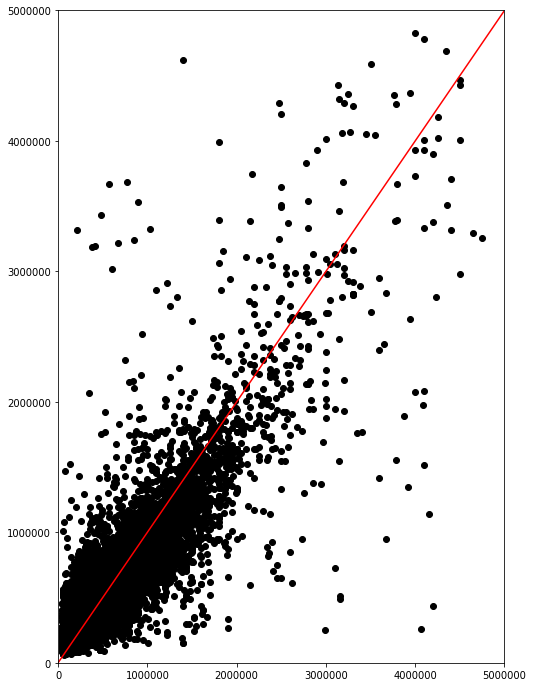

In [98]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, c='black')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
plt.xlim(0, 5000000)
plt.ylim(0, 5000000)
ax.add_line(line)
plt.show()

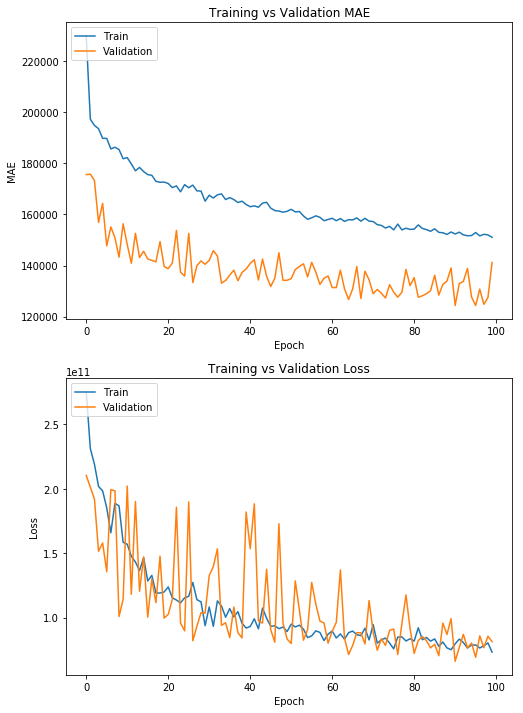

In [99]:
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

plot_hist(history.history, xsize=8, ysize=12)